# Sentiment classification of comments

The online store launches a new service. Now users can edit and supplement product descriptions, just like in wiki communities.
That is, clients propose their edits and comment on the changes of others.
The store needs a tool that will look for toxic comments and submit them for moderation.

We need to create a model that will classify comments as positive and negative. Here is a dataset with markup on the toxicity of edits.

Purpose: to build a model with the value of the quality metric *F1* not less than 0.75.

The main stages of our project will be:

* Loading and preparing data
* Training different models
* Evaluation of the F1-score
* Choosing the best model, testing it, checking the model for sanity
  
The project is made in **Jupyter Notebook**, Notebook server version: 6.1.4. Version **Python** 3.7.8.
The project used:
* **re**
* **Pandas**
* **NumPy**
* **scikit-learn**
* **MatPlotLib**
* **Spacy**
* **NLTK**
* **IPython**


## Preparing the data

In [1]:
# Import all the required libraries and modules.
import re

import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
import spacy
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
# Load and take a look at the dataset.
data = pd.read_csv('toxic_comments.csv')
display(data)
# Examine the basic information.
print(data.info())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


In [3]:
# Let's check the dataset for missing values.
print('Row duplicates number:', 
      data.duplicated().sum())

Row duplicates number: 0


In [4]:
%%time
# Let's lemmatize the texts.
nlp = spacy.load("en_core_web_sm")
data['lemmatized'] = data['text'].apply(
    lambda x: ' '.join(
        [y.lemma_ for y in nlp(x)]
    )
)

CPU times: user 42min 49s, sys: 2min 28s, total: 45min 18s
Wall time: 1h 6min 39s


In [5]:
# Let's get rid of the service word -PRON- of the Spacy library.
data['lemmatized'] = data['lemmatized'].str.replace('-PRON-', '')
# Remove extra characters using regular expressions.
data['lemmatized'] = data['lemmatized'].apply(
    lambda x: re.sub(
        r'[^a-zA-Z ]', ' ', x
    )
)
# Get rid of extra spaces.
data['lemmatized'] = data['lemmatized'].apply(
    lambda x: ' '.join(
        x.split()
    )
)

In [6]:
# Take a look at the updated dataset.
display(data)

,text,toxic,lemmatized
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour I be see...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I be really not try to edit war it be ...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can not make any real suggestion on imp...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,and for the second time of ask when your view ...
159567,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a ho...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm there s no actual article for pros...
159569,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


In [7]:
# Texts processed.
# Prepare the target feature.
features = data['lemmatized']
target = data['toxic']
# Let's split the dataset into training and test sets.
features_train, features_test, target_train, target_test = train_test_split(
    features, 
    target, 
    test_size=.2, 
    random_state=12345,
    stratify=target
)
# Sets are ready. Let's take a look at their sizes.
# The original data set had 159571 objects.
sets = [features_train, features_test, target_train, target_test]
set_names = ['features_train', 'features_test', 
             'target_train', 'target_test']
for name, kit in zip(set_names, sets):
    print('Size of the', name, 'set is', kit.shape)

Size of the features_train set is (127656,)
Size of the features_test set is (31915,)
Size of the target_train set is (127656,)
Size of the target_test set is (31915,)


Text(0.5, 1.0, 'The ratio of classes in the training set')

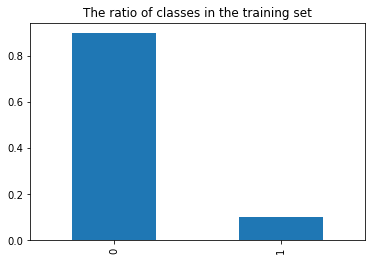

In [8]:
# Calculate the ratio of classes in the training set.
target_train.value_counts(normalize=True).plot(kind='bar')
plt.title('The ratio of classes in the training set')

In [9]:
# Let's change the format of the training and test sets of features.
corpus_train = features_train.values
corpus_test = features_test.values

In [10]:
# Load English stop-words.
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
# Create a TF-IDF counter.
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pavelsuhih/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Learn the vocabulary and create a TF-IDF training set matrix.
features_train_vec = count_tf_idf.fit_transform(corpus_train)
# Create a TF-IDF test sample matrix.
features_test_vec = count_tf_idf.transform(corpus_test)
# Let's check the sizes of the sets.
print('The size of the features_train_vec set is', features_train_vec.shape)
print('The size of the features_test_vec set is', features_test_vec.shape)

The size of the features_train_vec set is (127656, 137689)
The size of the features_test_vec set is (31915, 137689)


### Conclusion

During the preparation phase, we did the following:
1. The required libraries and modules are imported.
2. Downloaded and examined the dataset. Checked for complete duplicates.
3. Texts are lemmatized. After lemmatization, the texts were cleaned from unnecessary characters.
4. The dataset is divided into training (80%) and test (20%) sets.
5. An assessment of the ratio of classes in the training sample was carried out. There are significantly more non-toxic comments than toxic ones - almost 90% to 10%. It was decided to give more weight to class 1 (toxic comments) to achieve a balance.
6. A value counter TF-IDF has been created. The TF-IDF matrices of the training and test samples have been obtained. The expected sample sizes are obtained.

Let's move on to training models. We will train 2 models, choose the best one in terms of the F1 metric. Then we will do the sanity check.

## Training

### Logistic Regression

In [12]:
# Adjust model's hyperparameters using pipeline.
pipe_lr = Pipeline([
                ('clf', LogisticRegression(
                    random_state=12345, 
                    class_weight='balanced', 
                    solver='liblinear')
                )
]
)

grid_params_lr = [
    {'clf__penalty': ['l1', 'l2'],
     'clf__C': [1.0, 0.5]
    }
] 

grid_cv_lr = GridSearchCV(estimator=pipe_lr,
                          param_grid=grid_params_lr,
                          scoring='f1',
                          cv=10, 
                          n_jobs=-1)

grid_cv_lr.fit(features_train_vec, target_train)
# Best parameters are:
best_parameters = grid_cv_lr.best_params_
print('Best parameters are:\n', best_parameters)
# Best F1-score is:
best_cv_lr_score = grid_cv_lr.best_score_
print('Best F1-score is', best_cv_lr_score)

Best parameters are:
 {'clf__C': 1.0, 'clf__penalty': 'l1'}
Best F1-score is 0.7530169171108821


/Users/pavelsuhih/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [13]:
# Use the model with the best hyperparameters.
model_lr = LogisticRegression(random_state=12345, 
                              class_weight='balanced', 
                              solver='liblinear',
                              penalty='l1', 
                              C=1.0)
model_lr.fit(features_train_vec, target_train)
predicted_lr = model_lr.predict(features_test_vec)
print('F1-score is:', f1_score(target_test, predicted_lr))
lr_score = f1_score(target_test, predicted_lr)

F1-score is: 0.763586956521739


/Users/pavelsuhih/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Decision Tree

In [14]:
# Adjust model's hyperparameters using pipeline.
pipe_dt = Pipeline([
                ('model', DecisionTreeClassifier(
                    random_state=12345, 
                    class_weight='balanced'))])

grid_params_dt = [
    {'model__max_depth': [4, 8, 12],
     'model__min_samples_split': [2, 5, 10],
     'model__min_samples_leaf': [1, 2, 4]}
]

grid_cv_dt = GridSearchCV(estimator=pipe_dt,
                          param_grid=grid_params_dt,
                          scoring='f1',
                          cv=10, 
                          n_jobs=-1)

grid_cv_dt.fit(features_train_vec, target_train)
# Best parameters are:
best_parameters = grid_cv_dt.best_params_
print('Best parameters are:\n', best_parameters)
# Best F1-score is:
best_cv_dt_score = grid_cv_dt.best_score_
print('Best F1-score is', best_cv_dt_score)

Best parameters are:
 {'model__max_depth': 12, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}
Best F1-score is 0.5929686485433358


In [15]:
# Create a decision tree model.
model_dt = DecisionTreeClassifier(
    random_state=12345, 
    class_weight='balanced',
    max_depth=12,
    min_samples_split=2,
    min_samples_leaf=4
)
model_dt.fit(features_train_vec, target_train)
predicted_dt = model_dt.predict(features_test_vec)
print('F1-score is:', f1_score(target_test, predicted_dt))
dt_score = f1_score(target_test, predicted_dt)

F1-score is: 0.5948861366360368


### Conclusion

Initially, it was planned to create and test 4 models:
* Logistic regression
* Gradient boosting library Light GBM
* Decision tree
* Random forest
  
Unfortunately, over and over again, when trying to train gradient boosting and random forest models, the Jupyter Notebook core died. Attempts were made to simplify the code (in order to free up RAM), to exclude different models from the project execution process. However, for some reason, the kernel would die if any of these models were used in a project. It was decided to leave only logistic regression and decision tree models.

To balance classes, we used the class_weight parameter in the models, specifying the value 'balanced'.
  
The logistic regression model allowed us to achieve our goal. The achieved F1-score is greater than 0.75.
Let's check the model for sanity.

## General conclusion

In [16]:
# Let's do the sanity check.
dummy = DummyClassifier(random_state=12345, strategy='constant', constant=1)
dummy.fit(features_train_vec, target_train)
predicted_dummy = dummy.predict(features_test_vec)
print('Dummy model F1-score is', f1_score(target_test, predicted_dummy))
if f1_score(target_test, predicted_dummy) < lr_score:
    print('Selected model is sane')
else:
    print('Selected model is insane. Improvement is required.')

Dummy model F1-score is 0.18458475540386804
Selected model is sane


We loaded the data and examined it. The text has been processed. The process of text lemmatization turned out to be the most time-consuming for the computer processor. About an hour.
We then prepared the data for training the models. Vectorized features. Determined class imbalance.
Initially, it was planned to test 4 models, but due to technical problems, only two models were used.
The logistic regression model showed the value of the F1-score equal to 0.766, which tells us that the task was completed. This model is sane.